# Andrew Ng's Machine Learning MOOC: Week 6: Exploring Bias & Variance using Regularized Linear Regression

# Programming Exercise 5

## 0. Introduction
This notebook contains my solutions to the programming exercise for week 6 of Andrew Ng's famous Machine Learning MOOC on Coursera (https://www.coursera.org/learn/machine-learning). 

In this exercise, we develop a model using regularized linear regression, and use this to explore different bias-variance properties of the model.

Now, the course requires submission of programming exercises in either the MATLAB or OCTAVE programming language.

However since:
* I already code in Python for various web development and data science projects, and
* Python is the pre-eminent language currently used in data science and machine learning (and MATLAB and OCTAVE don't seem to be used anywhere near as much)

I decided it would be more valuable to me to use Python to complete the programming exercises.

I was therefore very pleased to find the following source, which has kindly written a set of python scripts to allow one to create Python implementations of the programming exercises for the course, and still submit them for scoring by the MOOC:
https://github.com/dibgerge/ml-coursera-python-assignments

**Thanks very much <i>dibgerge!</i>**


In addition to the course's own lecture materials, I also used a number of other sources to help me solve the programming exercises. These include:

### Other courses I've completed:
* Harvard's Using Python for Research on edX: https://www.edx.org/course/using-python-for-research
* UC San Diego's Python for Data Science, also on edX: https://www.edx.org/course/python-for-data-science-2
* MIT's Introduction to Computational Thinking and Data Science I and II, also on edX: https://www.edx.org/course/introduction-to-computational-thinking-and-data-4
* Imperial College London's Mathematics for Machine Learning I-III on Coursera: https://www.coursera.org/specializations/mathematics-machine-learning

### Books:
* Python Machine Learning by Sebastian Raschka and Vahid Mirjalili: https://sebastianraschka.com/books.html


### Blogs and websites
I found this blog a very useful reference:
* https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-5/

And of course, there's always StackOverflow!

One thing that struck me, looking at all of these different resources, is how many different ways there are to implement basically the same code in python, even using numpy and pandas dataframes! And that's before we think about object-oriented implementations, or using libraries such as scikitlearn.

OK, now that the introduction is complete, let's get started with some imports.
You can find instructions on how to install required libraries in the README file in *dibgerge*'s  [github repository](https://github.com/dibgerge/ml-coursera-python-assignments).

In [1]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Pandas library for manipulating data
import pandas as pd

# Plotting library
from matplotlib import pyplot as plt

# Random numbers
import random

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

<a id="section1"></a>
## 1 Regularized Linear Regression

First of all, we need to implement a regularized linear regression model to predict the amount of water flowing out of a dam based on the change of water level in a reservoir. In second half of the exercise we will run some diagnostics to debugging our algorithm and examine the effects of bias v.s.variance. 

### 1.1 Visualizing the dataset

We will begin by visualizing the dataset containing historical records on the change in the water level, $x$, and the amount of water flowing out of the dam, $y$.

This dataset is divided into three parts:

- A **training** set that we will train our model on: `X`, `y`
- A **cross validation** set for determining the regularization parameter, $\lambda$: `Xval`, `yval`
- A **test** set for evaluating performance. These are “unseen” examples which our model did not "see" during training: `Xtest`, `ytest`

First of all, let's load and plot the data. Generally I'd do this into a pandas datframe; however the data is given to us as a matlab (.mat) file, and I don't know how to load this into pandas...and just now I'd rather simply load it into a numpy array and get on with the exercise than lose an interesting half-hour getting diverted in finding out!

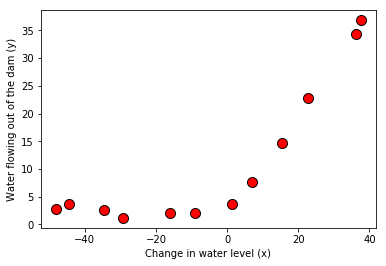

In [2]:
# Load from ex5data1.mat, where all variables will be store in a dictionary
data = loadmat(os.path.join('Data', 'ex5data1.mat'))

# Extract train, test, validation data from dictionary
# and also convert y's from 2-D matrix (MATLAB format) to a numpy vector
X, y = data['X'], data['y'][:, 0]
Xtest, ytest = data['Xtest'], data['ytest'][:, 0]
Xval, yval = data['Xval'], data['yval'][:, 0]

# m = Number of examples
m = y.size

# Plot training data
plt.plot(X, y, 'ro', ms=10, mec='k', mew=1)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

In [3]:
X.shape

(12, 1)

Looking at the data, we can see immediately that a straight-line is **unlikely** to be a good fit for this data - so simple *linear* regression (i.e. where we hypothesize that *y* is some function of *x* raised to the power 1) is not going to give us an accurate prediction for the values of *y*. Specifically, a straight line is going to *underfit* the data.

Instead, we're going to need to develop a hypothesis that predicts *y* is a function of *x* raised to some higher-order power - e.g. a quadratic function.

Looking at the plot is a great way to develop our hypothesis for a univariate, or even a bi-variate case (i.e. where we only have 1 or 2 independent variables, or "features"). However, in the case where we are trying to use 3 or more independent variables, then it becomes hard to develop our intuition for the likely best form of the hypothesis through plotting - since we can only plot in three dimensions!

For this reason, in this exercise we will first develop a hypothesis using simple linear regression, so we can look at the bias and variance and confirm in a more *mathematical* way that a straight-line *underfits* the data. We can then go on to look at higher-power functions, and see how these fit the data - ideally finding a model (/function /equation) that neither *underfits* the data (aka "high bias") nor *overfits* the data (aka "high variance").

### 1.2 Regularized linear regression cost function

In simple linear regression, our hypothesis for $h(\theta)$ is as follows:

$$ y = \theta_0x_0 + \theta_1x_1 $$

Where $\theta_0$ is the y-axis intercept where $x_0$ = 0 (otherwise referred to as the "bias term").

Thinking about how we vectorize this, it's useful to take the maths a little further here:

$$ y = \theta_0x_0 + \theta_1x_1 = \left (\sum_{i=1}^m \theta_ix_i \right) = \theta^{T}X $$

So, thinking ahead to data preparation, we're going to need to add a column of *1*s to our X matrix representing our $x$ training data (and the same for our cross-validation and test data)

#### Regularized linear regression cost function

The cost function for regularized linear regression is expressed as:

$$ J(\theta) = \frac{1}{2m} \left( \sum_{i=1}^m \left( h_\theta\left( x^{(i)} \right) - y^{(i)} \right)^2 \right) + \frac{\lambda}{2m} \left( \sum_{j=1}^n \theta_j^2 \right)$$

where $\lambda$ is a regularization parameter which controls the degree of regularization (helping prevent overfitting).

The regularization term puts a penalty on the overall cost J.

As the magnitudes of the model parameters $\theta_j$ increase, the penalty increases as well.

Note that we do not regularize the $\theta_0$ term.

####  Regularized linear regression gradient

Correspondingly, the partial derivative of the cost function for regularized linear regression is defined as:

$$
\begin{align}
& \frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} & \qquad \text{for } j = 0 \\
& \frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m} \theta_j & \qquad \text{for } j \ge 1
\end{align}
$$

Our task is to complete the function `linearRegCostFunction()`, which calculates the regularized linear regression cost function, and the gradient of the cost function at any point, with respect to $\theta$. We are going to do this using vectorized code - i.e. avoiding loops (which are computationally less efficient than vectors).

In [4]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    """
    Computes cost and gradient for regularized linear regression 
    with multiple variables.
    Computes the cost of using theta as the parameter for linear
    regression to fit the data points in X and y. 
    
    Parameters
    ----------
    X : array_like
        The dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The functions values at each datapoint. A vector of
        shape (m, ).
    
    theta : array_like
        The parameters for linear regression. A vector of shape (n+1,).
    
    lambda_ : float, optional
        The regularization parameter.
    
    Returns
    -------
    J : float
        The computed cost function. 
    
    grad : array_like
        The value of the cost function gradient w.r.t theta. 
        A vector of shape (n+1, ).
    
    Instructions
    ------------
    Compute the cost and gradient of regularized linear regression for
    a particular choice of theta.
    You should set J to the cost and grad to the gradient.
    """
    # 0. Pre-processing
    
    # 0.1 Initialize some important values
    m = y.size # number of training examples 
    J = 0 # cost - initialized to 0
    grad = np.zeros(theta.shape) # gradient of cost function - initialized as matrix of 0s

    # 0.2 split X and theta into term0 (the bias term) and the remaining terms
    
    # 0.2.1 split X into first column of intercept values, and all other columns 
    X0 = X[:, 0:1]
    X1 = X[:, 1:]
    
    # 0.2.2 Make a copy of theta, to avoid changing the original array, since
    # ...numpy arrays are passed by reference to functions
    theta = theta.copy()
    
    # 0.2.3 Slice Theta into first column relating to intercept values, and all other columns
    theta0 = theta[0:1]
    theta1 = theta[1:(len(theta)+1)]
    
    # 1. Calculate cost
    
    # 1.1 First term
    J_term1 = np.dot(X, theta) - y
    J_term1 = np.power(J_term1, 2)
    J_term1 = np.sum(J_term1) / (2*m)
    
    # 1.2 Second term - NB theta0 term is not regularized
    L2_term = (lambda_/(2*m)) * (np.sum(theta1**2)) # note more compact expression than 2nd and 3rd lines in J_term1 above
    
    # 1.3 Sum first term and second term
    J = J_term1 + L2_term

    # 2. Calculate gradient of cost with respect to theta
    
    # 2.1 Calculate gradient for first value of theta - which is not regularized
    error = np.dot(X, theta) - y
    temp = np.dot(X0.T, error)
    grad0 = temp / m
    grad0 = grad0.reshape((1, -1)) # change back to (1,) vector, rather than (1 x 1 matrix)
    
    # 2.2 Calculate gradient for remaining values of theta - which are regularized
    temp2 = np.dot(X1.T, error)
    temp2 = temp2 / m
    L2_term = (lambda_/m) * (theta1)
    grad1 = temp2 + L2_term
    grad1 = grad1.reshape((1, -1)) # change back to (1,) vector, rather than (1 x 1 matrix)
    
    # 2.3 Combine the two elements of the gradient back into a single matrix
    # ...and demote into a vector
    grad = np.concatenate([grad0, grad1], axis = 1)
    grad = grad.ravel()    
    
    return J, grad

**Test Cases**

When we've finished, we can run `linearRegCostFunction()` on a test case using theta initialized at `[1, 1]`.

We should see a cost function of `303.993` and a gradient of `[-15.30, 598.250]`.

In [5]:
theta = np.array([1, 1])
J, grad = linearRegCostFunction(np.concatenate([np.ones((m, 1)), X], axis=1), y, theta, 1)

print('Cost at theta = [1, 1]:\t   %f ' % J)
print('This value should be about 303.993192)\n' % J)

print('Gradient at theta = [1, 1]:  [{:.6f}, {:.6f}] '.format(*grad))
print(' (this value should be about [-15.303016, 598.250744])\n')

Cost at theta = [1, 1]:	   303.993192 
This value should be about 303.993192)

Gradient at theta = [1, 1]:  [-15.303016, 598.250744] 
 (this value should be about [-15.303016, 598.250744])



Let's also run a couple more test cases from the course's forum.

In [6]:
X_test1 = np.array([[1, 8, 1, 6], [1, 3, 5, 7], [1, 4, 9, 2]])
y_test1 = np.array([7, 6, 5])
theta_test1 = np.array([0.1, 0.2, 0.3, 0.4])

In [7]:
J, grad = linearRegCostFunction(X_test1, y_test1, theta_test1, 0)
print("Cost = {}".format(J))
print("Expected value = 1.3533")
print("Gradient = {}, {}, {}, {} ".format(*grad))
print("Expected values are: -1.400, -8.7333, -4.3333, -7.9333")

Cost = 1.3533333333333326
Expected value = 1.3533
Gradient = -1.3999999999999995, -8.73333333333333, -4.333333333333331, -7.93333333333333 
Expected values are: -1.400, -8.7333, -4.3333, -7.9333


OK, that looks correct.

Let's try the same case again, but with a different value for $\lambda$:

In [8]:
J, grad = linearRegCostFunction(X_test1, y_test1, theta_test1, 7)
print("Cost = {}".format(J))
print("Expected value = 1.6917")
print("Gradient = {}, {}, {}, {} ".format(*grad))
print("Expected values are: -1.400, -8.2667, -3.6333, -7.0000")

Cost = 1.691666666666666
Expected value = 1.6917
Gradient = -1.3999999999999995, -8.266666666666664, -3.633333333333331, -6.9999999999999964 
Expected values are: -1.400, -8.2667, -3.6333, -7.0000


Good stuff - our code appears to be working.

### 1.3 Fitting linear regression

Now we've got our cost function and gradient working correctly, we can "fit" the model and calculate the optimal values of $\theta$. We do this by calling the function `trainLinearReg()` (supplied to us by `dibgerge` in the module `utils.py` - thanks `dibgerge`!). It's worth taking a look at the code for this function, which uses `scipy`'s optimization module to minimize the cost function. The code also plots a line of best-fit for us.

In this part, we set regularization parameter $\lambda$ to zero. Why? Well, our current implementation of linear regression is trying to fit a 2-dimensional $\theta$, and regularization will not be incredibly helpful for a $\theta$ of such low dimension. In the later parts of the exercise, we will be using polynomial regression function, with which we will use regularization.

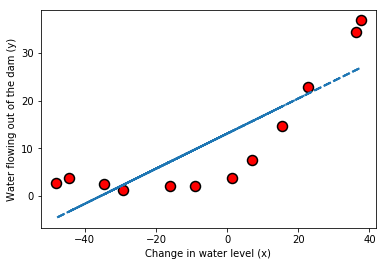

In [9]:
# add a columns of ones for the y-intercept
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
theta = utils.trainLinearReg(linearRegCostFunction, X_aug, y, lambda_=0)

#  Plot fit over the data
plt.plot(X, y, 'ro', ms=10, mec='k', mew=1.5)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.dot(X_aug, theta), '--', lw=2);

As we noted at the beginning of this section, we can see that the model is not a good fit to the data - the data are non-linear, while our hypothesis is linear.

When we're working in low dimensions for the independent variables (only 1 or 2 "features") visualization is very useful way of de-bugging and understanding the performance of our algorithm. Beyond this, however, it's not always easy to visualize the data and model (e.g. we might need to create numerous cross-tabs of 2-dimensional visualisations, and try to compare them). To help address this, in the next section, we will implement a function to generate learning curves that can help us debug our learning algorithm even if it is not easy to visualize the
data.

## 2 Bias vs. variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit; while models with high variance overfit to the training data, and don't generalize well to new, previously "unseen" data.

In this part of the exercise, we will plot training and test errors on a learning curve to diagnose bias-variance problems.

### 2.1 Learning Curves

Now well will implement code to generate the learning curves that will be useful in debugging learning algorithms.  A learning curve plots training and cross-validation error as a function of training set size. Our job is to fill in the function `learningCurve()` in the next cell, so that it returns a vector of errors for the training set and cross validation set.

To plot the learning curve, we need a training and cross validation set error for different training set sizes. To obtain different training set sizes, we  use different subsets of the original training set `X`. Specifically, for a training set size of $i$, you should use the first $i$ examples (i.e., `X[:i, :]`
and `y[:i]`).

We can use the `trainLinearReg()` function (by calling `utils.trainLinearReg(...)`) to find the optimal $\theta$ parameters for each sub-set. Note that the `lambda_` is passed as a parameter to the `learningCurve` function.

After learning the $\theta$ parameters, we compute the error on the training and cross validation sets. The training error for a dataset is defined as:

$$ J_{\text{train}} = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta \left( x^{(i)} \right) - y^{(i)} \right)^2 \right] $$

In particular, note that the training error does **not** include the regularization term. One way to compute the training error is to use our existing cost function and set $\lambda$ to 0 only when using it to compute the training error and cross validation error. 

Finally, when computing the training set error, we need to make sure to compute it on the training *subset* (i.e., `X[:n,:]` and `y[:n]`) instead of the entire training set. For the cross validation error, however, we need to compute it over the *entire* cross validation set. We will store the computed errors in the vectors `error_train` and `error_val`.

In [10]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    """
    Generates the train and cross validation set errors needed to plot a learning curve
    Returns the train and cross validation set errors for a learning curve. 
    
    In this function, we compute the training and cross-validation errors for
    dataset sizes from 1 up to m. In practice, when working with larger
    datasets, we might want to do this in larger intervals.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    y : array_like
        The function's values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The cross-validation dataset. Matrix with shape (m_val x n + 1) where m is the 
        total number of examples, and n is the number of features 
        before adding the bias term.
    
    yval : array_like
        The function's values at each cross-validation datapoint. A vector of
        shape (m_val, ).
    
    lambda_ : float, optional
        The regularization parameter.
        Default = 0
    
    Returns
    -------
    error_train : array_like
        A vector of shape m. error_train[i].
        Contains the training error for i examples.
    error_val : array_like
        A vector of shape m. error_val[i]
        Contains the validation error for i training examples.
    
    Notes
    -----
    - We evaluate the training error on the first i training
      examples (i.e., X[:i, :] and y[:i]).
    
      In contrast, we evaluate the cross-validation error on **the entire
      cross validation set** (Xval and yval).
    
    - We are using the cost function we defined above - linearRegCostFunction()) - 
      to compute the training and cross validation error. We therefore need to call 
      linearRegCostfunction() with the lambda argument set to 0 - as we don't 
      regularize this calculation.
      Note, however, that we still need to use lambda when calculating the optimum theta parameters.
    """
    # 0. Initialize some useful values and the outputs
    m = y.size
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # 1. Loop over the number of training examples
    for i in range(1, m+1):
        # 1.1. Define the sub-set of X and y values to use
        X_subset = X[:i, :]
        y_subset = y[:i]
        # 1.2 Calculate the optimum theta parameters for that sub-set
        theta = utils.trainLinearReg(linearRegCostFunction, X_subset, y_subset, lambda_)
        # 1.3 Apply those theta parameters to calculate the cost on the **training sub-set**
        # ...storing this value in error_train
        # ...making sure to set lambda_ to 0 for this and the following 
        # ...calculation (we don't regularize these parts)
        lambda_2 = 0 # define new variable to hard code the lambda_ parameter to be zero
        J_error_train, grad = linearRegCostFunction(X_subset, y_subset, theta, lambda_2)
        error_train[i-1] = J_error_train
        # 1.4 Apply the same theta parameters to calculate the cost on the **WHOLE cross-validation set**
        # ...storing this value in error_val
        J_error_val, grad = linearRegCostFunction(Xval, yval, theta, lambda_2)
        error_val[i-1] = J_error_val

    return error_train, error_val

No. of Training Examples	Train Error	Cross Validation Error
  	1		0.000000	205.121096
  	2		0.000000	110.302641
  	3		3.286595	45.010231
  	4		2.842678	48.368911
  	5		13.154049	35.865165
  	6		19.443963	33.829962
  	7		20.098522	31.970986
  	8		18.172859	30.862446
  	9		22.609405	31.135998
  	10		23.261462	28.936207
  	11		24.317250	29.551432
  	12		22.373906	29.433818


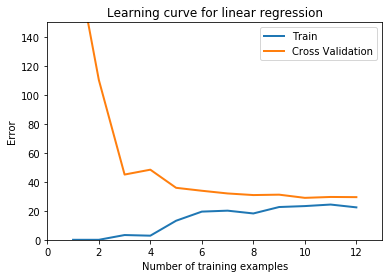

In [11]:
X_aug = np.concatenate([np.ones((m, 1)), X], axis=1)
Xval_aug = np.concatenate([np.ones((yval.size, 1)), Xval], axis=1)
error_train, error_val = learningCurve(X_aug, y, Xval_aug, yval, lambda_=0)

plt.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 150])

print('No. of Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

In the learning curve figure above, we see that both the train error and cross validation error remain high (> 20) when the number of training examples is increased. This reflects a high bias problem in the model - the linear regression model is too simple and is unable to fit our dataset well.

In the next section, we will implement polynomial regression to fit a better model for this dataset.

## 3 Polynomial regression

The problem with our linear model was that it was too simple for the data
and resulted in underfitting (high bias). In this part of the exercise, we will address this problem by adding more features. For polynomial regression, our hypothesis has the form:

$$
\begin{align}
h_\theta(x)  &= \theta_0 + \theta_1 \times (\text{waterLevel}) + \theta_2 \times (\text{waterLevel})^2 + \cdots + \theta_p \times (\text{waterLevel})^p \\
& = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_p x_p
\end{align}
$$

Notice that by defining $x_1 = (\text{waterLevel})$, $x_2 = (\text{waterLevel})^2$ , $\cdots$, $x_p =
(\text{waterLevel})^p$, we obtain a linear regression model where the features are the various powers of the original value (waterLevel).

Now, we will add more features using the higher powers of the existing feature $x$ in the dataset. Our task in this part is to complete the code in the function `polyFeatures()` in the next cell. The function maps the original training set $X$ of size $m \times 1$ into its higher powers. Specifically, when a training set $X$ of size $m \times 1$ is passed into the function, the function should return a $m \times p$ matrix `X_poly`, where column 1 holds the original values of X, column 2 holds the values of $X^2$, column 3 holds the values of $X^3$, and so on.

My approach here is to "promote" our `numpy` array into a `pandas` dataframe. It's then very easy to add new columns representing the original X data raised to higher powers. At the end we can convert this back to a `numpy` array very easily, too. I'm sure there's a fairly standard way of doing this with `numpy`, too - but I'm more familiar with `pandas` dataframes, and in any case would like to increase my practice in using them, since they are one of the most common data science tools in use.

In [12]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # Convert X from a numpy array to a dataframe for easier manipulation
    X_poly_df = pd.DataFrame(data=X)
    for column in range(p):
        X_poly_df[column] = X_poly_df[0]**(column+1)

    # Convert back from dataframe to numpy array
    X_poly = X_poly_df.values
    
    return X_poly

Let's test our function using some test cases from the course's forum.

First test case:

In [13]:
X_test1 = np.array([1, 2, 3, 4, 5, 6, 7])
X_test_poly1 = polyFeatures(X_test1, 4)
print("X_test_poly1 is:")
print(X_test_poly1)

X_test_poly1 is:
[[   1    1    1    1]
 [   2    4    8   16]
 [   3    9   27   81]
 [   4   16   64  256]
 [   5   25  125  625]
 [   6   36  216 1296]
 [   7   49  343 2401]]


In [14]:
X_test2 = np.array([1, 2, 3])
X_test_poly2 = polyFeatures(X_test2, 4)
print("X_test_poly2 is:")
print(X_test_poly2)

X_test_poly2 is:
[[ 1  1  1  1]
 [ 2  4  8 16]
 [ 3  9 27 81]]


Now we have a function that will map features to a higher dimension.

For the next part of the exercise, we will use a polynomial of degree 8.

If we run the training directly on the projected data, the algorithm will will not work well - as the features would be badly scaled (e.g., an example with $x = 40$ will now have a feature $x_8 = 40^8 = 6.5 \times 10^{12}$). We are therefore going to use feature normalization.

Before learning the parameters $\theta$ for the polynomial regression, we first call `featureNormalize()` to normalize the features of the training set, storing the mu, and sigma parameters separately. We already wrote a function to do this in the first exercise of this course. Here we will use the function supplied by the course  / `dibgerge` which is located in the `utils.py` module supplied with the code distribution for this programming exercise (thanks `dibgerge`!). `scipy` also has a normalization function we could use - see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization

The next cell applies our `polyFeatures()` function to the training data set, the test data set, and the cross-validation data set, and then *normalizes* each of these:

In [15]:
p = 8

# Map X onto Polynomial Features and Normalize
X_poly = polyFeatures(X, p)
X_poly, mu, sigma = utils.featureNormalize(X_poly)
X_poly = np.concatenate([np.ones((m, 1)), X_poly], axis=1)

# Map X_poly_test and normalize (using mu and sigma of **training data**)
X_poly_test = polyFeatures(Xtest, p)
X_poly_test -= mu
X_poly_test /= sigma
X_poly_test = np.concatenate([np.ones((ytest.size, 1)), X_poly_test], axis=1)

# Map X_poly_val and normalize (using mu and sigma **of training data**)
X_poly_val = polyFeatures(Xval, p)
X_poly_val -= mu
X_poly_val /= sigma
X_poly_val = np.concatenate([np.ones((yval.size, 1)), X_poly_val], axis=1)

print('Normalized Training Example 1:')
X_poly[0:2 :]

Normalized Training Example 1:


array([[ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
         0.30661792, -0.59087767,  0.3445158 , -0.50848117],
       [ 1.        , -0.80320484,  0.00125825, -0.24793699, -0.32702342,
         0.09339632, -0.43581761,  0.25541612, -0.44891249]])

In [16]:
print('Normalized Cross-Validation Example 1:')
X_poly_val[0:2 :]

Normalized Cross-Validation Example 1:


array([[ 1.        , -0.38916543, -0.72149541,  0.16876064, -0.69803716,
         0.30354037, -0.58940525,  0.34396872, -0.50824813],
       [ 1.        , -0.31677737, -0.80773065,  0.20193698, -0.71734245,
         0.31055382, -0.592639  ,  0.34512817, -0.50872536]])

*You should now submit your solutions.*

## 3.1 Learning Polynomial Regression

Now we've written the `polyFeatures()` function, we will train polynomial regression using our linear regression cost function.

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression. We are using the same cost function and gradient algorithms that we wrote for the earlier part of this exercise.

The code below will fit our training and cross-validation data sets to our linear regression algorithm, using a value for $\lambda$, the L2 regularization parameter, that we choose. Let's start with a value of 0:

Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	160.721900
  	2		0.000000	160.121511
  	3		0.000000	59.071624
  	4		0.000000	77.997697
  	5		0.000000	6.448825
  	6		0.000000	10.830519
  	7		0.000000	27.924529
  	8		0.000002	21.400711
  	9		0.000085	28.576513
  	10		0.029629	26.805988
  	11		0.036641	29.913319
  	12		0.029057	48.811833


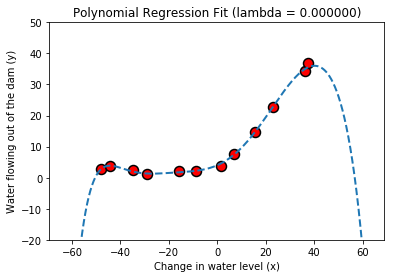

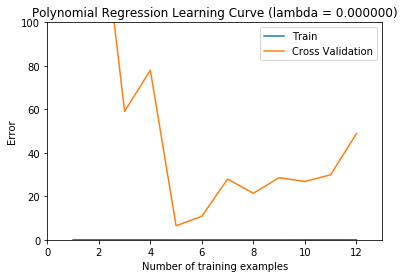

In [17]:
lambda_ = 0 # NB - we'll adjust this paramater throughout the exercise

theta = utils.trainLinearReg(linearRegCostFunction, X_poly, y,
                             lambda_=lambda_, maxiter=55)

# Plot training data and fit
plt.plot(X, y, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(X), np.max(X), mu, sigma, theta, p)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
plt.ylim([-20, 50])

plt.figure()
training_error, validation_error = learningCurve(X_poly, y, X_poly_val, yval, lambda_)
plt.plot(np.arange(1, 1+m), training_error, np.arange(1, 1+m), validation_error)

plt.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, 13, 0, 100])
plt.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, training_error[i], validation_error[i]))

So, what are we seeing?

The polynomial fit is able to follow the datapoints very well, thus obtaining a low training error. The chart at the top shows the X and y data, and the curve that our polynomial linear regression algorithm has "fitted" to the data. We can see that the fitted curve is a really good fit to the training data - which is why, on the bottom chart (the learning curve) we can see that the training error (blue line) essentially stays zero for all numbers of training samples.

We can also see, however, that the polynomial fit is very complex and even drops off at the extremes. This is an indicator that the polynomial regression model is overfitting the training data and will not generalize well. If we look at the cross-validation error, we can see that the cross validation error is high. There is a large gap between the training and cross validation errors, indicating a high variance problem - i.e. the fitted curve **overfits** the training data - and hence performs poorly on the cross-validation data.

### 3.2 Adjusting the regularization parameter

One way to combat the overfitting (high-variance) problem is to add regularization to the model. We can try different values for the $\lambda$ parameter to see how regularization can lead to a better model - by coming to different trade-offs between bias and variance.

To see this, we can modify the value we choose for the lambda parameter -  try $\lambda$ = 1, and 100. For each of these values, our code will generate a chart showing the polynomial fit to the data, and a chart showing the learning curve.

For $\lambda = 1$, the generated plots should look like the the charts below. We can see a polynomial fit that follows the data trend well (left) and a learning curve (right) showing that both the cross-validation and training error converge to a relatively low value. This shows the $\lambda = 1$ regularized polynomial regression model does not have high-bias or high-variance problems. In effect, it achieves a good trade-off between bias and variance.

<table>
    <tr>
        <td><img src="Figures/polynomial_regression_reg_1.png"></td>
        <td><img src="Figures/polynomial_learning_curve_reg_1.png"></td>
    </tr>
</table>

For $\lambda = 100$, shown in the chart below, we can see a polynomial fit that does not follow the data well. In this case, there is too much regularization and the model is unable to fit the training data.

![](Figures/polynomial_regression_reg_100.png)

### 3.3 Selecting $\lambda$ using a cross validation set

From the previous parts of the exercise, we saw that the value of $\lambda$ can significantly affect the results of regularized polynomial regression on the training and cross validation set.

In particular, a model without regularization ($\lambda = 0$) fits the training set well, but does not generalize. Conversely, a model with too much regularization ($\lambda = 100$) does not fit the training set and testing set well. A good choice of $\lambda$ (e.g., $\lambda = 1$) can provide a good fit to the data.

In this section, we will implement an automated method to select the optimum $\lambda$ parameter. We will use a cross-validation set to evaluate how good each $\lambda$ value is.

After selecting the best $\lambda$ value using the cross-validation set, we can then evaluate the model on the test set to estimate how well the model will perform on further unseen data (the test set).

Our task is to complete the code in the function `validationCurve()`. We are asked to use the `utils.trainLinearReg()` function (supplied in the code distribution) to train the model using different values of $\lambda$ and compute the training error and cross validation error.

We are directed to try $\lambda$ in the following range: [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10].

In [18]:
def validationCurve(X, y, Xval, yval):
    """
    Generate the train and validation errors needed to plot a validation
    curve that we can use to select lambda_.
    
    Parameters
    ----------
    X : array_like
        The training dataset. Matrix with shape (m x n) where m is the 
        total number of training examples, and n is the number of features 
        including any polynomial features.
    
    y : array_like
        The function's values at each training datapoint. A vector of
        shape (m, ).
    
    Xval : array_like
        The validation dataset. Matrix with shape (m_val x n) where m is the 
        total number of validation examples, and n is the number of features 
        including any polynomial features.
    
    yval : array_like
        The function's values at each validation datapoint. A vector of
        shape (m_val, ).
    
    Returns
    -------
    lambda_vec : list
        The values of the regularization parameters which were used in 
        cross-validation.
    
    training_error : numpy array
        The training error computed at each value for the regularization
        parameter.
    
    validation_error : numpy array
        The validation error computed at each value for the regularization
        parameter.
    
    Instructions
    ------------
    Fill in this function to return training errors in `error_train` and
    the validation errors in `error_val`. The vector `lambda_vec` contains
    the different lambda parameters to use for each calculation of the
    errors, i.e, `error_train[i]`, and `error_val[i]` should give you the
    errors obtained after training with `lambda_ = lambda_vec[i]`.

    Note
    ----
    You can loop over lambda_vec with the following:
    
          for i in range(len(lambda_vec))
              lambda = lambda_vec[i]
              # Compute train / val errors when training linear 
              # regression with regularization parameter lambda_
              # You should store the result in error_train[i]
              # and error_val[i]
              ....
    """
    # Selected values of lambda
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

    # Initialize two lists to hold training and validation errors
    training_error_list = []
    validation_error_list = []

    # Loop over selected values of lambda and calculate training and validation errors
    for lambda_ in lambda_vec:
        # calculate optimum theta parameters        
        theta = utils.trainLinearReg(linearRegCostFunction, X, y,
                             lambda_=lambda_, maxiter=55)
        # calculate training and validation errors - with value of lambda = 0
        lambda2 = 0
        training_error, grad = linearRegCostFunction(X, y, theta, lambda2)
        validation_error, grad = linearRegCostFunction(Xval, yval, theta, lambda2)
        
        # Append training and validation errors to our lists
        training_error_list.append(training_error)
        validation_error_list.append(validation_error)
    
    #print("training_error_list is {}".format(training_error_list))
    #print("validation_error_list is {}".format(validation_error_list))
    
    # Convert lists to numpy arrays
    training_error = np.array(training_error_list)
    #print("training_error is:")
    #print(training_error)
    validation_error = np.array(validation_error_list)
    #print("validation_error is:")
    #print(validation_error)
    
    return lambda_vec, training_error, validation_error

OK, let's try a test case from the course's forum

In [19]:
# initialize the test case's values
X_test2 = np.array([[1, 2], [1, 3], [1, 4], [1, 5]])
y_test2 = np.array([8, 7, 3, 2])
Xval_test2 = np.array([[1, 7], [1, -2]])
yval_test2 = np.array([2,12])

# call validationCurve() function
lambda_vec, error_train, error_val = validationCurve(X_test2, y_test2, Xval_test2, yval_test2)
print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

lambda		Train Error	Validation Error
 0.000000	0.225000	12.025000
 0.001000	0.225000	12.015215
 0.003000	0.225001	11.995666
 0.010000	0.225012	11.927501
 0.030000	0.225108	11.734882
 0.100000	0.226163	11.084967
 0.300000	0.234692	9.419011
 1.000000	0.309028	5.295139
 3.000000	0.650391	0.900389
 10.000000	1.569444	2.247222


OK, that matches what I was expecting.

Now let's run our function and plot a cross validation curve of error v.s. $\lambda$ that allows you select the optimum $\lambda$ parameter to use.

lambda		Train Error	Validation Error
 0.000000	0.144071	17.645756
 0.001000	0.129075	11.803271
 0.003000	0.171756	16.370695
 0.010000	0.220983	17.017624
 0.030000	0.281950	12.819507
 0.100000	0.459319	7.587007
 0.300000	0.921782	4.636756
 1.000000	2.076198	4.260605
 3.000000	4.901380	3.822917
 10.000000	16.092273	9.945554


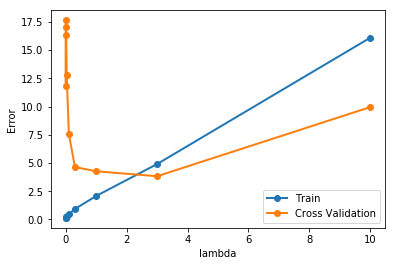

In [20]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-o', lambda_vec, error_val, '-o', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')

print('lambda\t\tTrain Error\tValidation Error')
for i in range(len(lambda_vec)):
    print(' %f\t%f\t%f' % (lambda_vec[i], error_train[i], error_val[i]))

Looking at the chart, we can see that the best value of $\lambda$ is around 3. Due to randomness in the training and validation splits of the dataset, the cross validation error can sometimes be lower than the training error.

### 3.4  Computing test set error

Right, we've now written (well, adapted) our function to calculate the cross validation error for various values of the regularization parameter $\lambda$.

Based on that, we've selected an optimal value for $\lambda$ of around 3.

However, to better understand of the model’s performance in the real world, we still need to evaluate the “final” model  - including our selected value of $\lambda$ on a test set that was not used in any part of training (that is, it was neither used to select the $\lambda$ parameters, nor to learn the model parameters $\theta$).

So we will now compute the test error using the best value of $\lambda$ you found.

In our cross validation, we obtained a test error of 3.822 for $\lambda = 3$, so we'll use 3.

In [21]:
lambda_ = 3

First we will calculate the optimum values of theta, applied to our polynomial test data set `X_poly_test` - which we normalized above:

In [22]:
theta = utils.trainLinearReg(linearRegCostFunction, X_poly_test, ytest, lambda_, maxiter=55)

Then we calculate the cost of the fitted linear regression model, with these values of theta:

In [23]:
test_error, grad = linearRegCostFunction(X_poly_test, ytest, theta, lambda_)
print("test_error is {}".format(test_error))

test_error is 8.88413175032396


Finally, let's plot our selected linear regression function, applied to the test data:

(-20, 50)

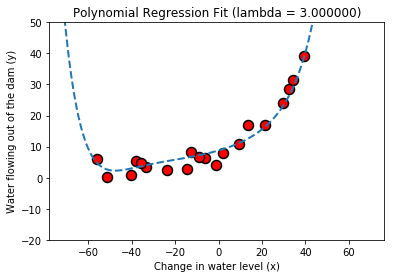

In [24]:
plt.plot(Xtest, ytest, 'ro', ms=10, mew=1.5, mec='k')

utils.plotFit(polyFeatures, np.min(Xtest), np.max(Xtest), mu, sigma, theta, p)

plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.title('Polynomial Regression Fit (lambda = %f)' % lambda_)
plt.ylim([-20, 50])

So, how do we interpret this? Well
- We can see from the chart that our line has a reasonable fit with the test data - there are not too many outliers; and our line doesn't move around all over the place as it would if we were *over-fitting* the data to any major degree.
- Our total error of 8.9 isn't *very high* - though, to be honest with you, I think it would be valuable to have a more robust statistical definition of what constitutes an acceptable error

### 3.5 Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when we plot learning curves to debug our algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.

Concretely, to determine the training error and cross validation error for $i$ examples, we need to first randomly select $i$ examples from the training set and $i$ examples from the cross validation set. We can then learn the $\theta$ parameters using the randomly chosen training set and evaluate them on the randomly chosen training set and cross validation set. These steps are then repeated multiple times (say 50) and the averaged error calculated and used to determine the training error and cross validation error for *i* examples.

I'm going to admit, my solution for this is a bit *hacky*, e.g.:
- I mix up using numpy arrays and pandas DataFrames - mostly because I'm not an expert in using numpy, and find pandas a bit more intuitive
- My solution contains two nested for-loops, which I find acceptable over the very simple dataset we're dealing with here; but won't give good performance on million-item datasets; or million-feature datasets.

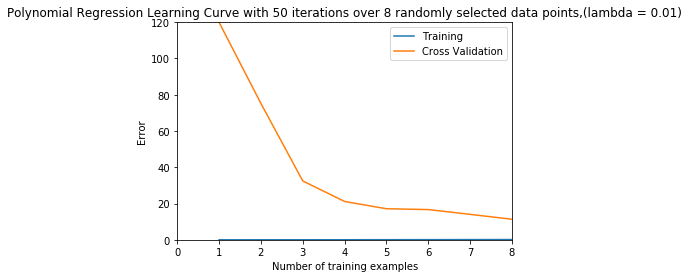

In [25]:
# Set the number of iterations (e.g. 50)
iterations = 50

# Set the number of random examples to choose (i - say 8 out of 12?)
num_examples = 8

# set lambda_
lambda_ = 0.01

# Instantiate two Pandas DataFrames to store our results
# NB we will need to drop the initial column of zeros...
# ...before calculating the average
error_train_df = pd.DataFrame(np.zeros((num_examples, 1)))
error_val_df = pd.DataFrame(np.zeros((num_examples, 1)))

# Iterate over our number of iterations
for iteration in range(iterations):
    # Extract **the same** randomly selected i rows from X_train_poly, y, X_val_poly, yval
    # randomly choose i indices
    random_train = random.sample(range(0, len(y)), num_examples)
    # instantiate new arrays to hold our randomly selected rows
    X_poly_subset = np.zeros((len(random_train), X_poly.shape[1]))
    y_subset = np.zeros(len(random_train))
    X_poly_val_subset = np.zeros((len(random_train), X_poly_val.shape[1]))
    y_val_subset = np.zeros(len(random_train))
    # iterate over our arrays and extract our randomly chosen i rows into the new arrays
    for i in range(len(random_train)):
        X_poly_subset[i] = X_poly[random_train[i]].copy()
        y_subset[i] = y[random_train[i]].copy()
        X_poly_val_subset[i] = X_poly_val[random_train[i]].copy()
        y_val_subset[i] = yval[random_train[i]].copy()

    # Calculate the learning curve for the randomly selected i rows
    error_train, error_val = learningCurve(X_poly_subset, y_subset, X_poly_val_subset, y_val_subset, lambda_=lambda_)
    
    # Store the results in our pandas DataFrames
    error_train_Series = pd.Series(error_train, name = iteration+1)
    error_train_df = pd.concat([error_train_df, error_train_Series], axis = 1)

    error_val_Series = pd.Series(error_val, name = iteration+1)
    error_val_df = pd.concat([error_val_df, error_val_Series], axis = 1)
    
# Drop the initial column of zeros from our DataFrames
error_train_df = error_train_df.drop([0], axis = 1)
error_val_df = error_val_df.drop([0], axis = 1)

# Calculate the average of all iterations
error_train_df['average'] = error_train_df.mean(axis=1)
error_val_df['average'] = error_val_df.mean(axis=1)

# Plot the learning curve chart based on these averages
plt.figure()
plt.plot(np.arange(1, 1+num_examples), error_train_df['average'], np.arange(1, 1+num_examples), error_val_df['average'])
plt.title('Polynomial Regression Learning Curve with {} iterations over {} randomly selected data points,(lambda = {})'.format(iterations, num_examples, lambda_))
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0, num_examples, 0, error_val_df['average'].max()])
plt.legend(['Training', 'Cross Validation'])
